In [ ]:

import collections
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

# Plot

In [21]:
# from csv
results = pd.read_csv("./out/2024-12-10-compare_injections_2e6runs_sj")

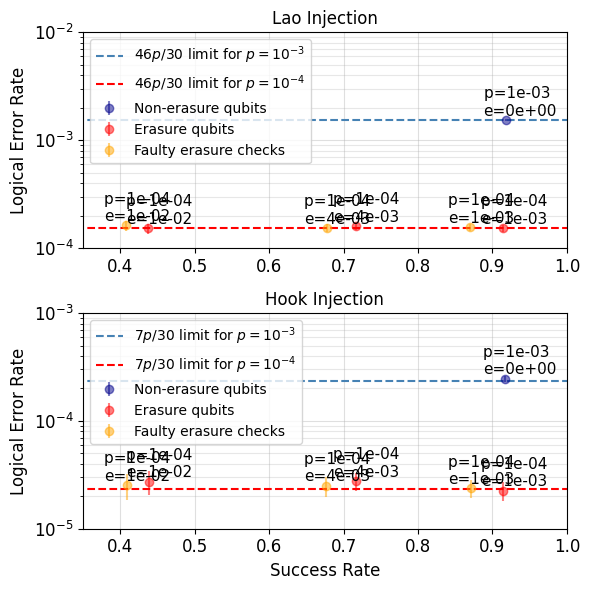

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6))
from itertools import cycle
from matplotlib import rcParams
rcParams['font.family'] = 'DejaVu Sans'

label_fontsize = 12
title_fontsize = 12
legend_fontsize = 10

theory_coef_dict = {
    ('Lao', 3): 46,
    ('hook', 3): 7,
}

x_axis = "success_rate" # attempts_per_shot

d=3
results['attempts_per_shot'] = 1 / results['success_rate']

# each plot is for different injection type

# add different colors for different injection types
# colors = ['b', '#1f77b4', 'darkblue', 'r', 'orange', '#d62728']
colors = [
    # '#7f7f7f',   # Gray',
    # '#87CEFA',  # Light Blue
    '#00008B',  # Dark Blue
    # '#A52A2A',  # Brown
    'r',  # Light Red
    'orange'   # Dark Red
]
color_generator = cycle(colors)
color_dict = dict(zip(results['injection_type'].unique(), colors))

labels = ['Non-erasure qubits','Erasure qubits','Faulty erasure checks']
label_generator = cycle(labels)

for i, injection_type in enumerate(['Lao','hook']):
    # Filter for injection type
    ax = axes[i]

    df_filtered_list = []
    df_filtered_list.append(
        results[(results['injection_type'] == injection_type) & (results['distance'] == d) & (results['em'] == 0) & (results['e'] == 0)]
    )

    df_filtered_list.append(
        results[(results['injection_type'] == injection_type) & (results['distance'] == d) & (results['em'] == 0) & (results['e'] != 0)]
    )

    df_filtered_list.append(
        results[(results['injection_type'] == injection_type) & (results['distance'] == d) & (results['em'] != 0) & (results['e'] != 0)]
    )

    for df_filtered in df_filtered_list:
        ax.errorbar(
            df_filtered[x_axis], 
            df_filtered['logical_err'], 
            yerr=1.96 * df_filtered['std_err'], 
            fmt='o', 
            color=next(color_generator), # color=color_dict[injection_type],
            label=next(label_generator), 
            alpha=0.5
        )
    
        # annotate all points
        for i, row in df_filtered.iterrows():
            if row['qubit_type'] == 'fullerasure':
                ax.annotate(f'p={row["pe"]:.0e} \ne={row["e"]:.0e}',  (row[x_axis]-0.03, row["logical_err"]*1.1), fontsize=11)
            if row['qubit_type'] == 'noerasure':
                ax.annotate(f'p={row["p"]:.1e}',  (row[x_axis], row["logical_err"]))
    

    th_coef = theory_coef_dict[(injection_type,d)]
    p = 1e-3
    ax.hlines(
        th_coef*p/30, 0, 1e5, 
        colors='steelblue', #'coral' if injection_type=='hook' else 'deepskyblue', slategray
        linestyles='dashed', 
        label=f'${th_coef}p/30$ limit for $p=10^{{-3}}$'
    )
    p = 1e-4
    ax.hlines(
        th_coef*p/30, 0, 1e5, 
        colors='r',  # 'r' if injection_type=='hook' else '', 
        linestyles='dashed', 
        label=f'${th_coef}p/30$ limit for $p=10^{{-4}}$'
    )


    
    if d==2:
        ax.set_xlim(1, 4)
    elif d==3 and x_axis == "attempts_per_shot":
        ax.set_xlim(1, 4)
        ax.set_xscale('log')
    elif d==3 and x_axis == 'success_rate':
        ax.set_xlim(0.35, 1)
    ylimits = [1e-5, 1e-3] if injection_type=='hook' else [1e-4,1e-2]
    ax.set_ylim(ylimits)
    ax.set_yscale('log')
    ax.set_ylabel('Logical Error Rate', fontsize = label_fontsize)
    
    ax.set_title(f"{injection_type.title()} Injection", fontsize = title_fontsize)
    ax.grid(which='major', alpha=0.4)
    ax.grid(which='minor', alpha=0.3)
    ax.legend(fontsize = legend_fontsize)
    ax.tick_params(labelsize=label_fontsize)

axes[1].set_xlabel(x_axis.replace('_', ' ').title(), fontsize = label_fontsize)
fig.tight_layout()
plt.savefig(f'./out/{date.today()}-injection_comparison.svg')
plt.show()
